# Implementation of Convolutional Neural Network (CNN)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from sklearn.manifold import TSNE

import random
import zipfile
import os
from tqdm import tqdm
from tqdm.notebook import tqdm
import itertools
from PIL import Image
from PIL import ImageOps
from tabulate import tabulate

import time
import cv2
import gc
import PIL
from collections import OrderedDict

import platform
import psutil
import glob

## Load and Prepare the Dataset

In [2]:
# Define the data directory (adjust to your dataset structure)
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

# Verify file structure
for dirname, _, filenames in os.walk("/kaggle/input/gastric-cancer-data"):
    for filename in filenames[:]:  # limit output to avoid spam
        print(os.path.join(dirname, filename))

# Gather file paths and labels
file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

# Display sample
df

/kaggle/input/gastric-cancer-data/HMU-GC-Clinical.csv
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2940.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3357.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3294.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3050.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3119.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3133.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2937.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_3743.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1592.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_332.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_1810.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image/MUC/MUC_2896.png
/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K

file_path label
0      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   TUM
1      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   STR
2      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   LYM
3      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   STR
4      /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   STR
...                                                  ...   ...
31091  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   MUS
31092  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   LYM
31093  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   ADI
31094  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   ADI
31095  /kaggle/input/gastric-cancer-data/HMU-GC-HE-30...   DEB

[31096 rows x 2 columns]

### **Random Image Visualization**

Class: TUM, Count: 3887
Class: STR, Count: 3887
Class: LYM, Count: 3887
Class: MUC, Count: 3887
Class: DEB, Count: 3887
Class: MUS, Count: 3887
Class: NOR, Count: 3887
Class: ADI, Count: 3887


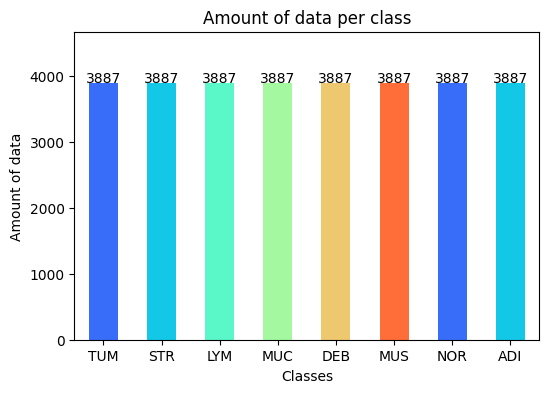

In [3]:
class_counts_train = df['label'].value_counts()
for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar', color=sns.color_palette('rainbow'))
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
plt.title('Amount of data per class')

for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

**Visualize Images for Each Class**

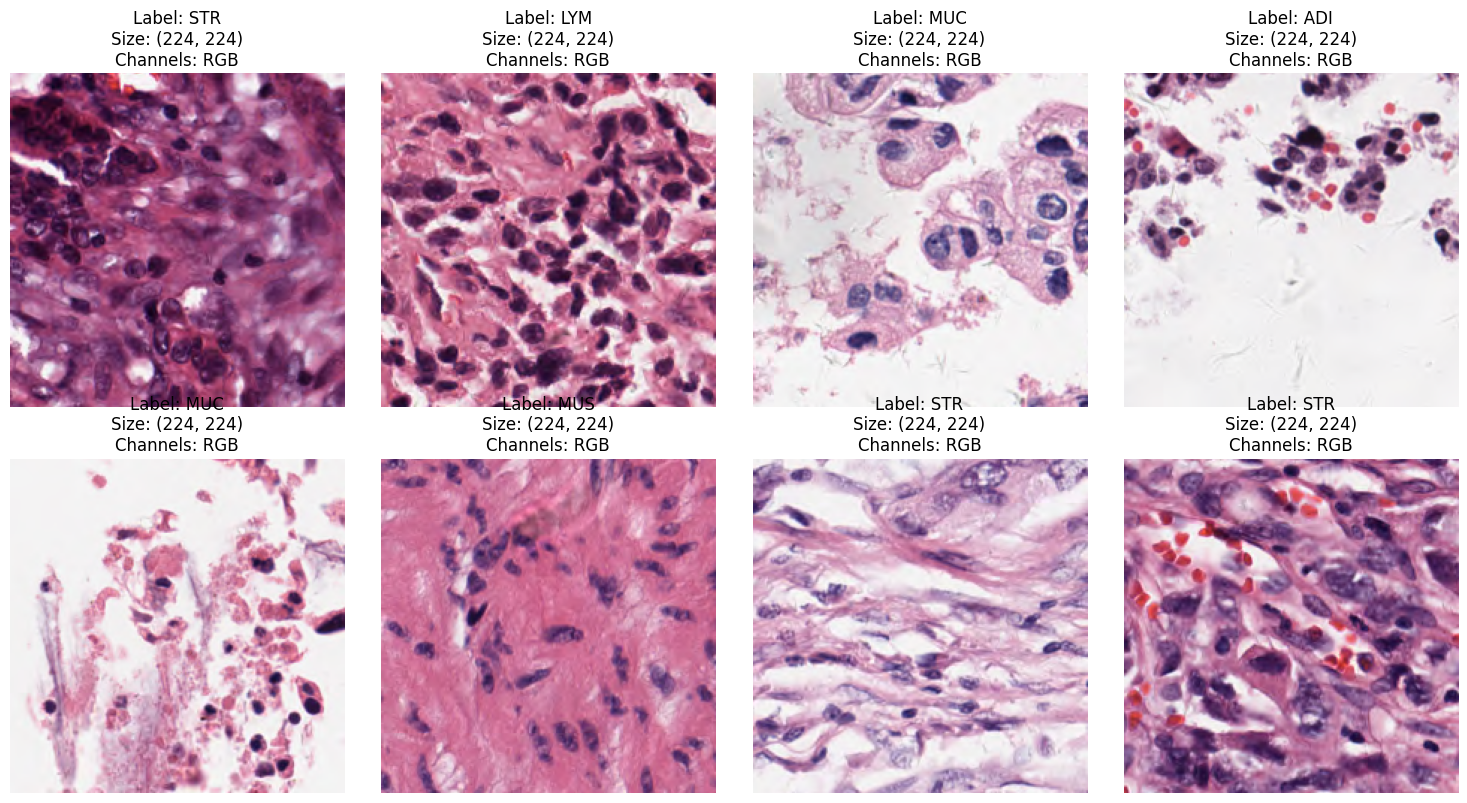

In [4]:
num_images_to_show = 8
rows = 2
cols = 4
plt.figure(figsize=(15, 8))

for i in range(num_images_to_show):
    random_index = random.randint(1, len(df) - 1)
    random_row = df.iloc[random_index]
    file_path = random_row['file_path']
    label = random_row['label']
    image = Image.open(file_path)
    size = image.size
    channels = 'Grayscale' if image.mode == 'L' else 'RGB'

    plt.subplot(rows, cols, i + 1)  # Create subplots for each image
    plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Split the Dataset into Training, Validation and Test set**

In [5]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, stratify=temp_dataframe['label'], random_state=42)

In [6]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  24876
Validation Data:  3110
Test Data:  3110
-------------------------------------------
Total amounts of data in the dataset:  31096


**Dataset Class, Dataloader and Transform**

In [7]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        # Always convert labels to integers, regardless of is_lb
        self.is_lb = True
        self.label_map = {'ADI': 0, 'DEB': 1, 'LYM': 2, 'MUC': 3, 'MUS': 4, 'NOR': 5, 'STR': 6, 'TUM': 7}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)
        image = image.convert('RGB')
        # Convert label to integer using label_map
        label = self.label_map[self.dataframe.iloc[index]['label']]

        # Check if label is within the valid range and convert to LongTensor
        if not 0 <= label < 8:
            print(f"Warning: Invalid label value: {label} at index {index}, Image Path: {img_path}")
            label = 0  # Or handle the invalid label in another way

        # Ensure the image is of the correct data type
        image = self.normalize(image).type(torch.FloatTensor)

        return image, torch.tensor(label, dtype=torch.long) # Convert label to LongTensor

In [8]:
batch = 32

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

## Define a Custom CNN Model

In [9]:
# 2nd Try This Sample
class CustomCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(CustomCNN, self).__init__()
        # Convolutional feature extractor
        self.conv_blocks = nn.Sequential(
            # Block 1: 3 input channels -> 64 filters
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # conv1: low-level feature extraction
            nn.BatchNorm2d(64),                            # normalize feature maps for stable training
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # down-sample (200→100)
            nn.Dropout(0.25),                              # dropout to regularize early layers

            # Block 2: 64 -> 128 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # increase filters to capture more complex features
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (100→50)
            nn.Dropout(0.25),

            # Block 3: 128 -> 256 filters
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (50→20)
            nn.Dropout(0.25),

            # Block 4: 256 -> 512 filters
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (25→12)
            nn.Dropout(0.30),                              # more dropout as representations grow

            # Block 5: 512 -> 512 filters
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                               # (12→6)
            nn.Dropout(0.30),

            # Block 6: 512 -> 1024 filters (adds capacity for high-level patterns)
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # (No further pooling; feature maps are now 7x7 after Block 5)
        )
        # Global average pooling (1x1 output per channel) to reduce parameters
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # output: [batch, 1024, 1, 1]
        # Classifier: flatten and linear layer to 8 classes
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),       # strong dropout before final classification
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# Train the Model and Plot Loss Curves

##### **Define the model, move to device, then define optimizer and criterion**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing to improve generalization
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
# AdamW optimizer with L2 regularization(weight decay) for better generalization.

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

**Data transforms for training and validation**

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.RandomHorizontalFlip(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((180, 180)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [13]:
data_dir = "/kaggle/input/gastric-cancer-data/HMU-GC-HE-30K/all_image"

image_datasets = {
    x: datasets.ImageFolder(data_dir, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [14]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 80  # Adjust as needed

Number of classes:8


## Evaluate Model and Training using Custom Model (Slow Without AMP)

Epoch 1/80
Train Loss: 1.5214 Acc: 0.4825
Val Loss: 1.6058 Acc: 0.4756
Epoch 2/80
Train Loss: 1.3286 Acc: 0.5822
Val Loss: 1.3416 Acc: 0.5827
Epoch 3/80
Train Loss: 1.2302 Acc: 0.6295
Val Loss: 1.3156 Acc: 0.6068
Epoch 4/80
Train Loss: 1.1737 Acc: 0.6608
Val Loss: 1.3915 Acc: 0.5666
Epoch 5/80
Train Loss: 1.1276 Acc: 0.6832
Val Loss: 1.2699 Acc: 0.6278
Epoch 6/80
Train Loss: 1.0971 Acc: 0.6968
Val Loss: 1.1829 Acc: 0.6708
Epoch 7/80
Train Loss: 1.0613 Acc: 0.7152
Val Loss: 1.2029 Acc: 0.6552
Epoch 8/80
Train Loss: 1.0364 Acc: 0.7282
Val Loss: 1.1247 Acc: 0.6807
Epoch 9/80
Train Loss: 1.0150 Acc: 0.7393
Val Loss: 1.2765 Acc: 0.6389
Epoch 10/80
Train Loss: 0.9952 Acc: 0.7482
Val Loss: 1.0481 Acc: 0.7195
Epoch 11/80
Train Loss: 0.9781 Acc: 0.7573
Val Loss: 1.0818 Acc: 0.7017
Epoch 12/80
Train Loss: 0.9577 Acc: 0.7694
Val Loss: 1.1051 Acc: 0.7064
Epoch 13/80
Train Loss: 0.9380 Acc: 0.7783
Val Loss: 1.0714 Acc: 0.7110
Epoch 14/80
Train Loss: 0.9182 Acc: 0.7900
Val Loss: 1.1015 Acc: 0.7092
E

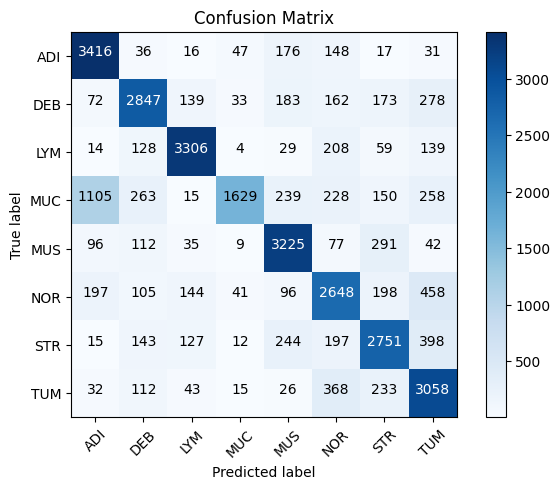

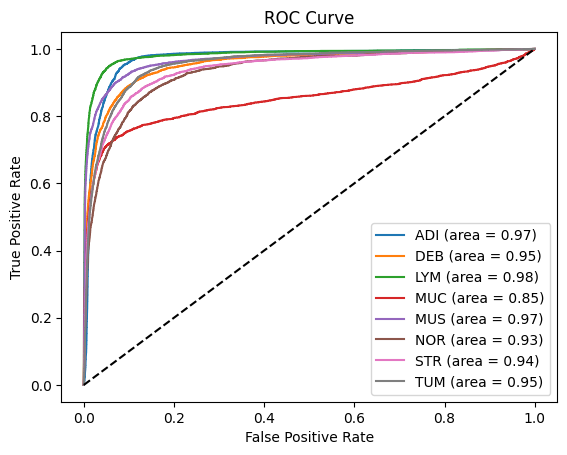

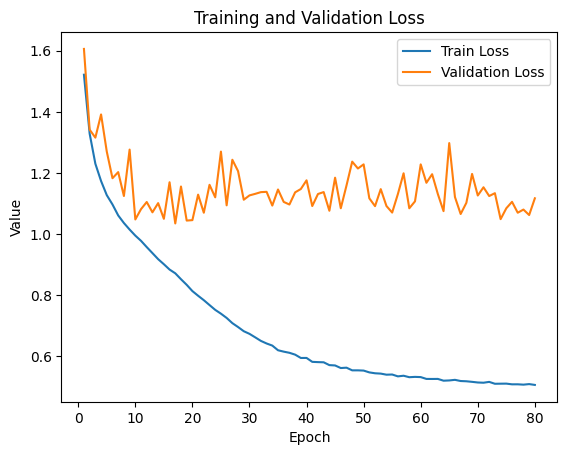

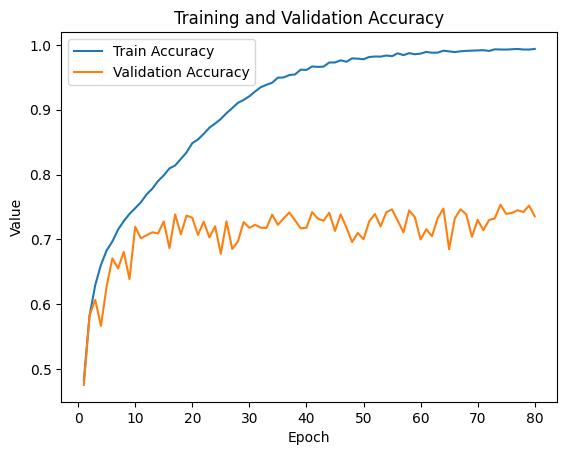

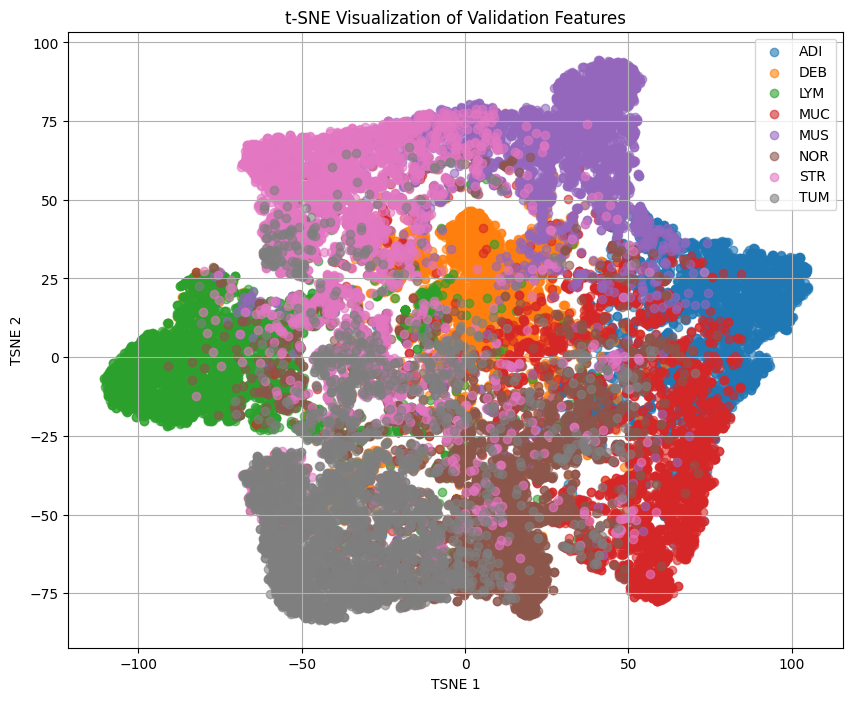

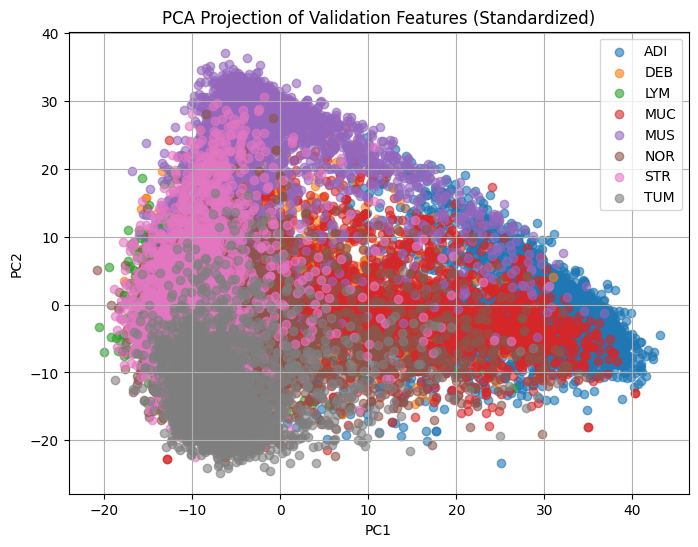

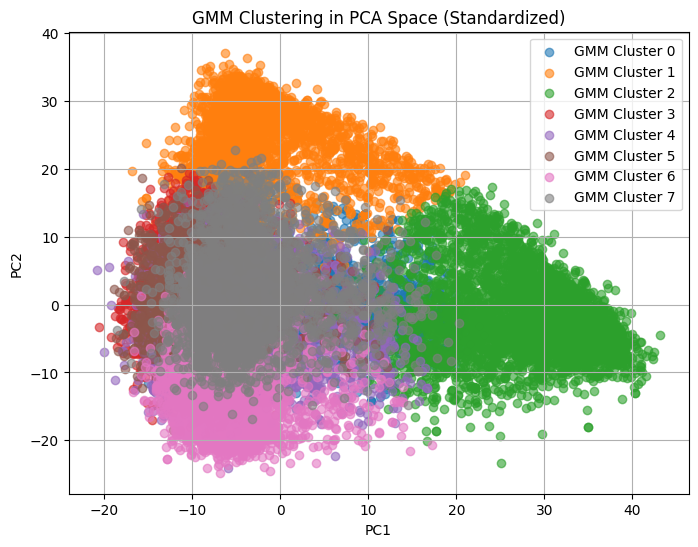

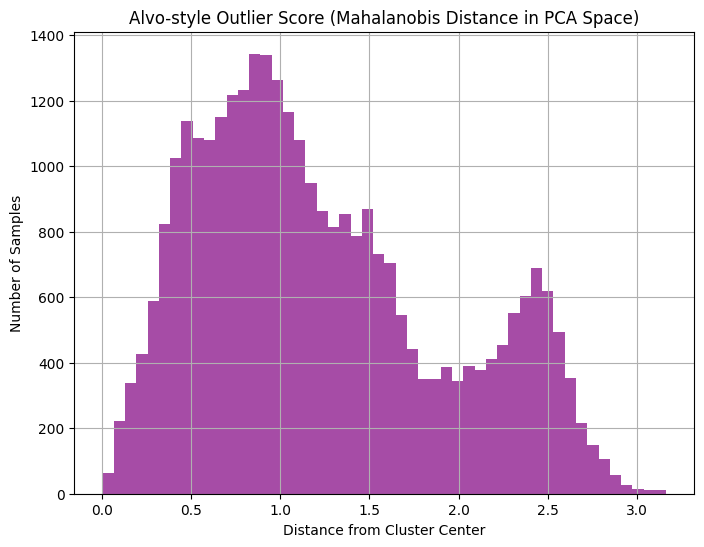

In [15]:
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # Track losses and accuracies
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                
            # Clear CUDA cache after each epoch or phase
            torch.cuda.empty_cache()
            gc.collect()

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Confusion Matrix & Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)

    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

    # ROC Curve
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Loss Plot
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Accuracy Plot
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Extract features using the penultimate layer of the model
    model.eval()
    features = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model.conv_blocks(inputs)  # Get conv features
            outputs = model.global_avg_pool(outputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            features.append(outputs.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    # t-SNE for 2D projection
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    for class_idx in range(num_classes):
        idxs = labels_list == class_idx
        plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=class_names[class_idx], alpha=0.6)

    plt.legend()
    plt.title("t-SNE Visualization of Validation Features")
    plt.xlabel("TSNE 1")
    plt.ylabel("TSNE 2")
    plt.grid(True)
    plt.show()

    # Standardize the features before PCA or GMM
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # PCA Visualization (2D)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        idxs = labels_list == i
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=class_names[i], alpha=0.6)

    plt.legend()
    plt.title('PCA Projection of Validation Features (Standardized)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

    # GMM Clustering Visualization
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    gmm_labels = gmm.fit_predict(features_scaled)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        idxs = gmm_labels == i
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=f'GMM Cluster {i}', alpha=0.6)

    plt.legend()
    plt.title('GMM Clustering in PCA Space (Standardized)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()

    # Alvo Method (Mahalanobis Distance)
    mean_vector = np.mean(pca_result, axis=0)
    cov_matrix = np.cov(pca_result.T)
    inv_cov_matrix = inv(cov_matrix)

    distances = [mahalanobis(x, mean_vector, inv_cov_matrix) for x in pca_result]

    plt.figure(figsize=(8, 6))
    plt.hist(distances, bins=50, color='purple', alpha=0.7)
    plt.title("Alvo-style Outlier Score (Mahalanobis Distance in PCA Space)")
    plt.xlabel("Distance from Cluster Center")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.show()